<a href="https://colab.research.google.com/github/custom-hyper/Analytics/blob/main/Trading_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Environment

In [12]:
#@title Connect to FNS { display-mode: "code" }
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
#@title Install Dependencies
!pip install statistics --quiet
!pip install yfinance --quiet
!pip install pytrends --quiet
!pip install pycoingecko --quiet
!pip install pandas --quiet
!pip install Backtesting --quiet
!pip install mplfinance --quiet
!pip install configparser --quiet
!pip install psycopg2-binary==2.8.6 --quiet

#@title Ta-lib – Extra steps { display-mode: "code" }
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb 
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb 
!pip install ta-lib --quiet

(Reading database ... 124017 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...


In [14]:
#@title Import Project  Dependencies { display-mode: "code" }
import requests
import mplfinance as fplt
from datetime import datetime as dt
from datetime import timedelta
from datetime import date
import talib as ta
import time
import json
import seaborn as sns
from google.colab import data_table
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import logging
import sys
from tqdm.notebook import tqdm
import os
import sqlite3 as sq
import psycopg2 as pg
import configparser
from sqlalchemy import create_engine
from pycoingecko import CoinGeckoAPI
import numpy as np
#from __future__ import division

In [26]:
#@title Set up SQLite { display-mode: "code" }
#@title  Connect { display-mode: "code" }
path = '/content/drive/MyDrive/workspace/pipelines/db/' #@param {type: 'string'
database = "db.sqlite" #@param {type: 'string'
conn_SQLite = sq.connect(path+database)

In [27]:
#@title  Load Watchlist { display-mode: "code" }

proprietary_watchlist_hist = 'proprietary_watchlist_hist'

df = pd.read_sql('select * from {}'.format(proprietary_watchlist_hist), conn_SQLite)

conn_SQLite.close()

df

,id,name,market_cap,total_volume,price_change_percentage_24h,float_rotation_24h,dilution_ratio,last_updated,watchlist_name,query_date,query_timestamp,price,stdev_30d,rel_volume,sma10,sma20,sma50,sma100,sma200,atr
0,boson-protocol,Boson Protocol,22735596.0,2647212.0,0.199110,0.116435,1.921776,2022-11-30T16:31:27.654Z,Big Mover,2022-11-30,1669830399836809,0.226113,0.036285,2.373528,0.236445,0.230872,None,None,None,0.025020
1,cirus,Cirus,6279795.0,888523.0,0.436414,0.141489,4.049311,2022-11-30T16:31:22.105Z,Big Mover,2022-11-30,1669830399836809,0.104490,0.016003,1.981777,0.079955,0.099962,None,None,None,0.006433
2,dego-finance,Dego Finance,21988029.0,131537308.0,0.980987,5.982224,2.206431,2022-11-30T16:31:21.009Z,Big Mover,2022-11-30,1669830399836809,2.930772,0.361600,11.380353,1.595000,1.646000,None,None,None,0.147720
3,echain-network,Echain Network,1261241.0,722975.0,0.193435,0.573225,2.998096,2022-11-30T16:31:43.401Z,Big Mover,2022-11-30,1669830399836809,0.011622,0.000725,0.607829,NaN,NaN,None,None,None,NaN
4,ethernity-chain,Ethernity Chain,36441150.0,46174891.0,0.217002,1.267109,1.853566,2022-11-30T16:31:07.634Z,Big Mover,2022-11-30,1669830399836809,1.961142,0.288772,0.443833,2.152000,2.377500,None,None,None,0.333615
5,fable-of-the-dragon,Fable Of The Dragon,6808679.0,3201364.0,1.156411,0.470189,1.000000,2022-11-30T16:31:07.873Z,Big Mover,2022-11-30,1669830399836809,0.653046,0.157343,1.901553,0.088374,NaN,None,None,None,NaN
6,perpetual-protocol,Perpetual Protocol,36593942.0,62397121.0,0.240260,1.705122,2.130627,2022-11-30T16:31:02.489Z,Big Mover,2022-11-30,1669830399836809,0.530140,0.068522,2.539198,0.480184,0.521048,None,None,None,0.057995
7,torum,Torum,4909700.0,1006573.0,0.285311,0.205017,4.690027,2022-11-30T16:31:24.272Z,Big Mover,2022-11-30,1669830399836809,0.028608,0.003210,2.880318,0.023547,0.024628,None,None,None,0.002149
8,wing-finance,Wing Finance,23844092.0,17116964.0,0.195366,0.717870,1.674653,2022-11-30T16:31:16.018Z,Big Mover,2022-11-30,1669830399836809,7.985427,1.031493,3.106896,6.918000,7.763000,None,None,None,0.701805


# Search Token


In [29]:

CoinGecko_id = "boson-protocol" #@param {type:"string"}
yahoo_id = "MATIC-USD" #@param {type:"string"}


# Big  Picture

Text(0.5, 1.0, 'Google Trends')

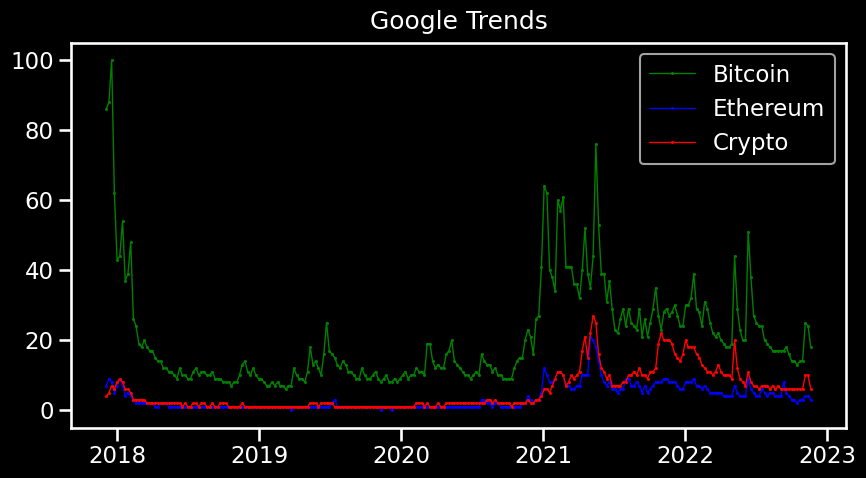

In [30]:
#@title
#@title Google Trends
import seaborn as sns
from pytrends.request import TrendReq
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
# Only need to run this once, the rest of requests will use the same session.
pytrend = TrendReq()


pytrend.build_payload(kw_list=['Bitcoin', 'Ethereum','Crypto'])

# Interest Over Time
interest_over_time_df = pytrend.interest_over_time()
df=interest_over_time_df

plt.plot( 'Bitcoin', 'y1', data=df, marker='x', color='green',linestyle='-', linewidth=1,ms=1.5 )
plt.plot( 'Ethereum', 'y2', data=df, marker='x', color='blue',linestyle='-', linewidth=1,ms=1.5 )
plt.plot( 'Crypto', 'y3', data=df, marker='x', color='red',linestyle='-', linewidth=1,ms=1.5 )

#plt.plot( 'Cosmos Crypto', 'y5', data=df, marker='x', color='red',linestyle='-', linewidth=1,ms=1.5 )
plt.legend()


# title
plt.title('Google Trends', loc='center',pad=10)


In [31]:
#@title
#@title Crypto Fear & Greed Index

import requests

from datetime import datetime
import time
import json
from google.colab import data_table
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt



#General Information table
response = requests.get("https://api.alternative.me/fng/?limit=0")
output = response.text
json_parsed = json.loads(output)

df = pd.json_normalize(json_parsed)


df1 = pd.concat([pd.json_normalize(x) for x in df['data'].values.tolist()])
timeseries = df1['timestamp']
df1['date'] = pd.to_datetime(df1['timestamp'], unit = 's')

df_fear_greed = pd.concat([df1['date'], df1['value']], axis=1)
df3 = pd.concat([df1['date'], df1['value_classification']])

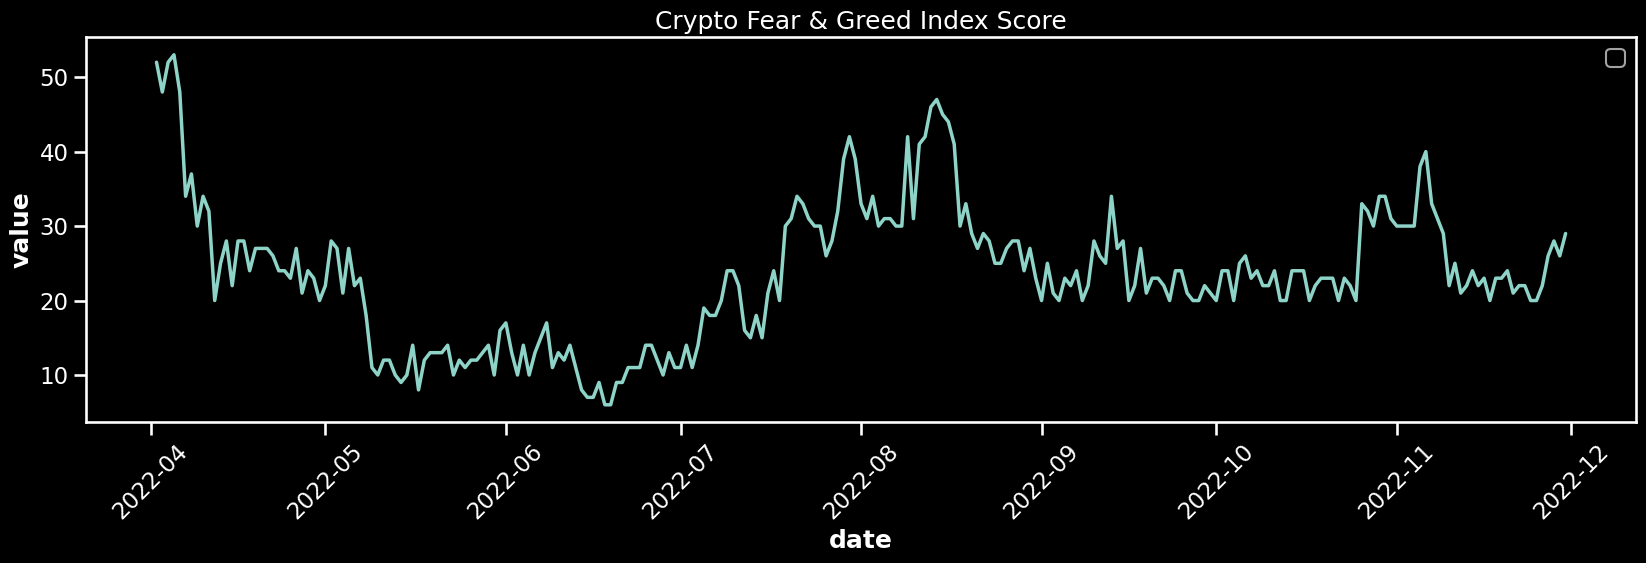

ValueError: ignored

<Figure size 500x500 with 1 Axes>

In [32]:
#@title
#@title


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.style.use("dark_background")
#sns.set_theme(style="darkgrid")

#Choose the date range
df_fear_greed = df_fear_greed[(df_fear_greed['date'] > '2022-04-01')]

df_fear_greed['value'] = df_fear_greed['value'].astype(int)
 
plt.figure(figsize=(20, 5))

sns.lineplot(data=df_fear_greed, linewidth=2.5, x="date", y="value", sort=False)
#sns.lineplot(df_fear_greed=df, linewidth=2.5, x="date", y="TotalCapMrktCurUSD")
plt.title('Crypto Fear & Greed Index Score')

plt.xticks(rotation=45)

plt.legend()


df_fear_greed.head(1)


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

df_fear_greed['daily_ret'] = df_fear_greed['value'].pct_change(1)

ECDF = sns.displot(df_fear_greed, x="daily_ret", kind="ecdf")

Histogram = df_fear_greed['daily_ret'].hist(bins = 50)

sns.lineplot(data=df_fear_greed, linewidth=2.5, x="date", y="daily_ret", sort=False)
plt.title('Daily Return %')

plt.show()

# Technical Analysis

In [46]:
#@title S&P 500
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import talib as ta

ticker='SPY'


ticker_y = yf.Ticker(ticker)
Name = ticker_y.info['longName']
ticker_y.info

data = yf.download(tickers=ticker, period='200d')


[*********************100%***********************]  1 of 1 completed


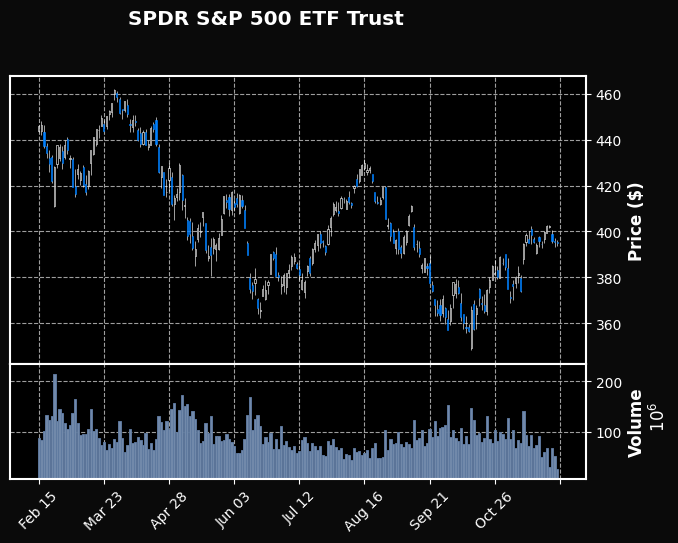

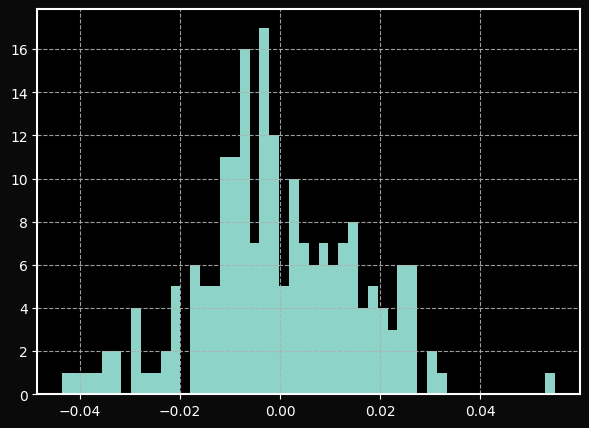

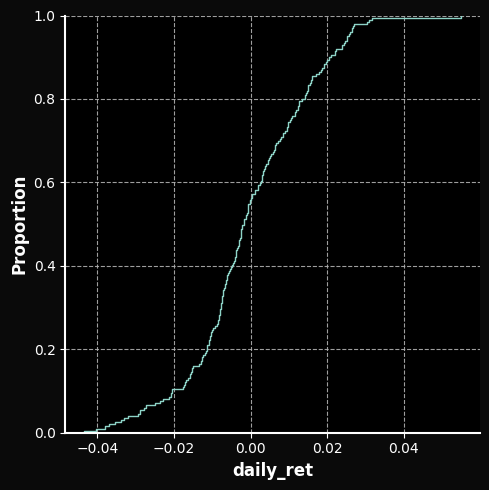

In [47]:
#@title
import mplfinance as fplt

fplt.plot(
            data,
            type='candle',
            style='mike',
            title=Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            )

data['daily_ret'] = data['Close'].pct_change(1)
data['daily_ret'].hist(bins = 50,figsize = (7,5))

sns.displot(data, x="daily_ret", kind="ecdf")



[*********************100%***********************]  1 of 1 completed



Related News – ^VIX

– Stock Market News for Nov 23, 2022
– Stock Market News for Nov 21, 2022
– Short Holiday Week Could Result in Upside for Stocks
– Three seasonal effects in the stock market begin around Thanksgiving, and this year it’s time to buy this asset class
– Stock Market News for Nov 15, 2022
– Stock Market News for Nov 14, 2022
– Stock Market News for Nov 11, 2022


/usr/local/lib/python3.7/dist-packages/mplfinance/plotting.py:678: UserWarning:

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.



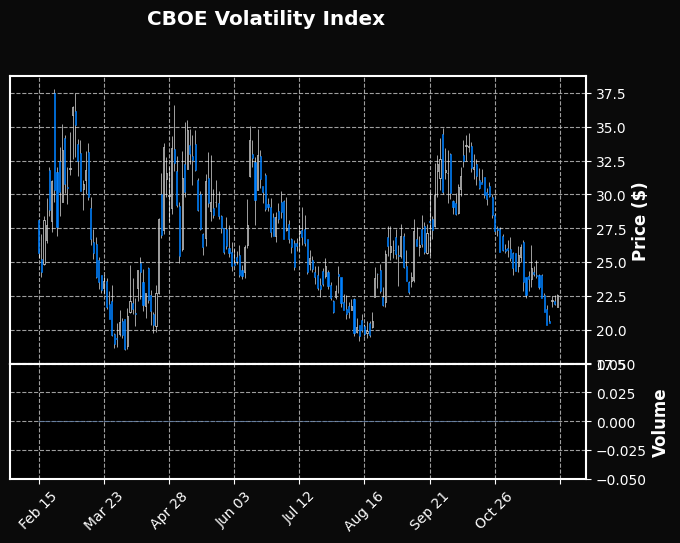

Text(0.5, 1.0, 'Daily Return %')

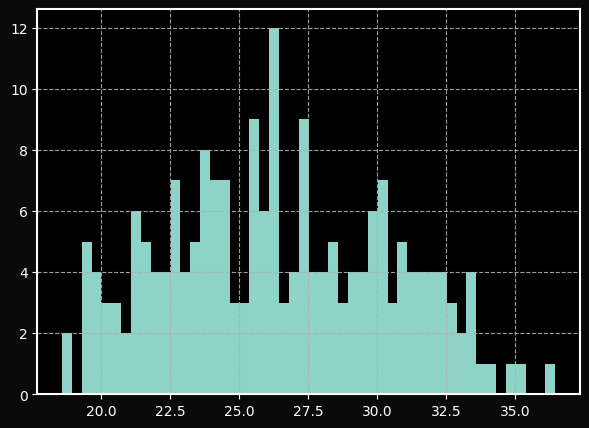

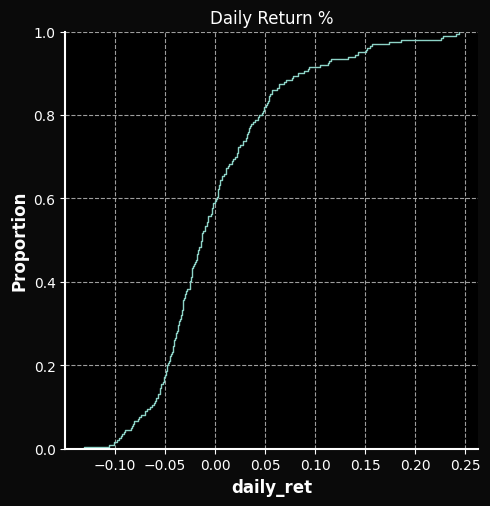

In [56]:
#@title  VIX
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go

ticker='^VIX'


ticker_y = yf.Ticker(ticker)
Name = ticker_y.info['shortName']
ticker_y.info

data = yf.download(tickers=ticker, period='200d')

fig = go.Figure(data=[go.Candlestick(x=data.index,
                                     open=data['Open'],
                                     high=data['High'],
                                     low=data['Low'],
                                     close=data['Close'])])

fig.update_layout(
    title=Name,
    yaxis_title='Price',
   
)

fig.show()
ticker_y.info

print('')
print('Related News – ' +ticker)
print('')

try:
  for i in range(1,10):
    print('– ' + ticker_y.news[i]['title'])

except Exception:
  pass

import mplfinance as fplt

fplt.plot(
            data,
            type='candle',
            style='mike',
            title=Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            )

data['daily_ret'] = data['Close'].pct_change(1)
data['Close'].hist(bins = 50,figsize = (7,5))
sns.displot(data, x="daily_ret", kind="ecdf")


plt.title('Daily Return %')

[*********************100%***********************]  1 of 1 completed



Related News – QQQ

– Jobless Claims, Goods Orders, Airline Metrics Up Ahead of Holiday
– Stocks surge at open, Nasdaq solidly in the green
– Nasdaq rips higher, S&P 500 gains as tech lifts stocks
– ETF investors are ‘trying to get back to core set of exposures’ amid surging inflows, expert says
– How Every Leveraged ETF Can Cost Investors Money
– Nasdaq leads market declines, British pound loses value against U.S. dollar
– Economic Data Gradually Dwindles: Jobless Claims, Productivity & More


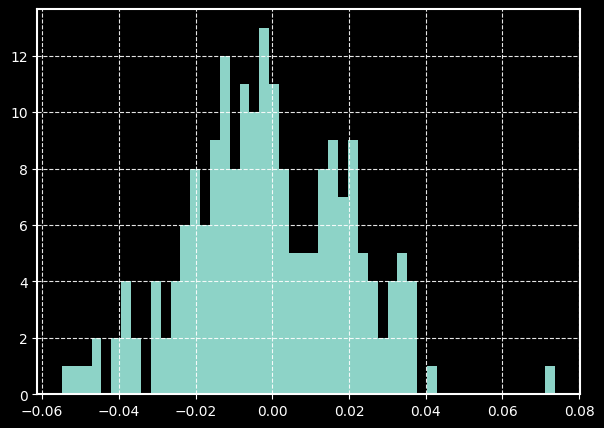

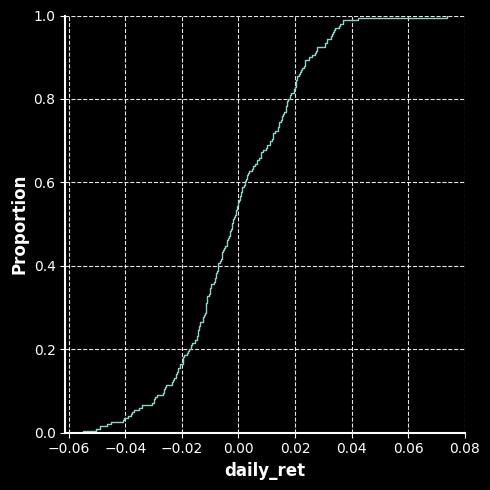

In [57]:
#@title NASDAQ
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go

plt.style.use("dark_background")

ticker='QQQ'


ticker_y = yf.Ticker(ticker)
Name = ticker_y.info['longName']
ticker_y.info

data = yf.download(tickers=ticker, period='200d')

fig = go.Figure(data=[go.Candlestick(x=data.index,
                                     open=data['Open'],
                                     high=data['High'],
                                     low=data['Low'],
                                     close=data['Close'])])

fig.update_layout(
    title=Name,
    yaxis_title='Price',
   
)

fig.show()
ticker_y.info

print('')
print('Related News – ' +ticker)
print('')

try:
  for i in range(1,10):
    print('– ' + ticker_y.news[i]['title'])

except Exception:
  pass

data['daily_ret'] = data['Close'].pct_change(1)
data['daily_ret'].hist(bins = 50,figsize = (7,5))
sns.displot(data, x="daily_ret", kind="ecdf")

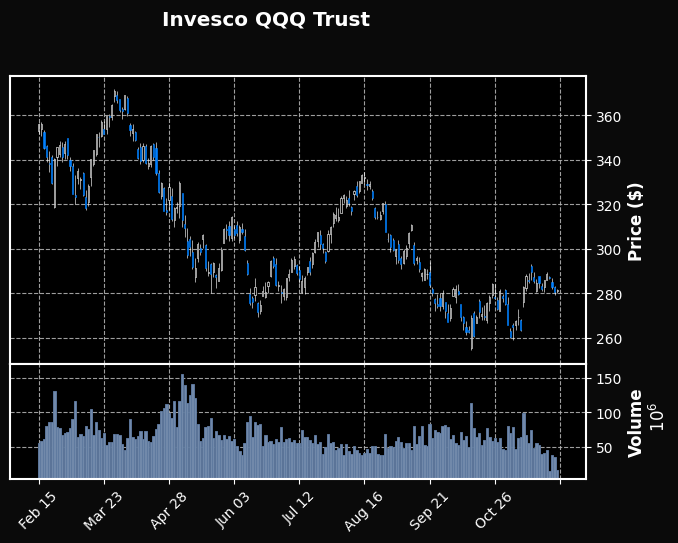

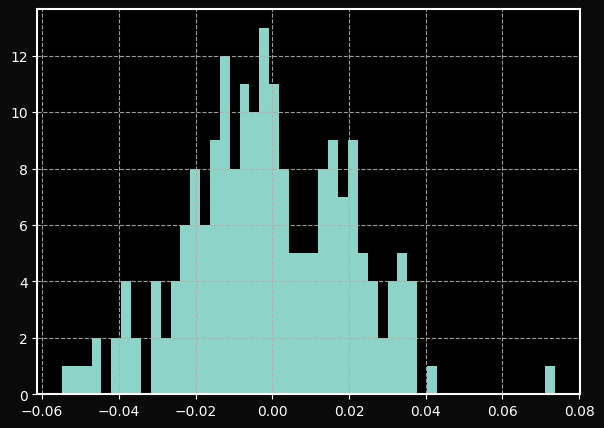

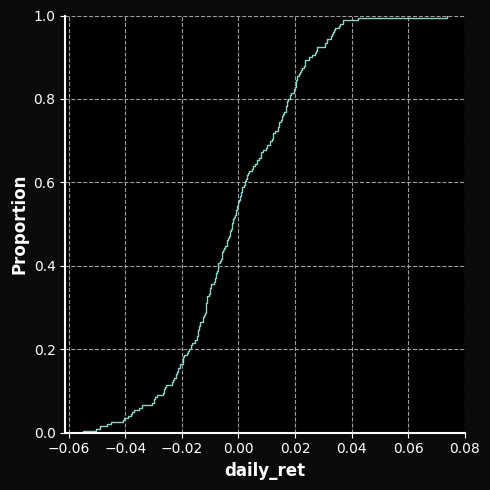

In [58]:
#@title

fplt.plot(
            data,
            type='candle',
            style='mike',
            title=Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            )


data['daily_ret'] = data['Close'].pct_change(1)
data['daily_ret'].hist(bins = 50,figsize = (7,5))
sns.displot(data, x="daily_ret", kind="ecdf")

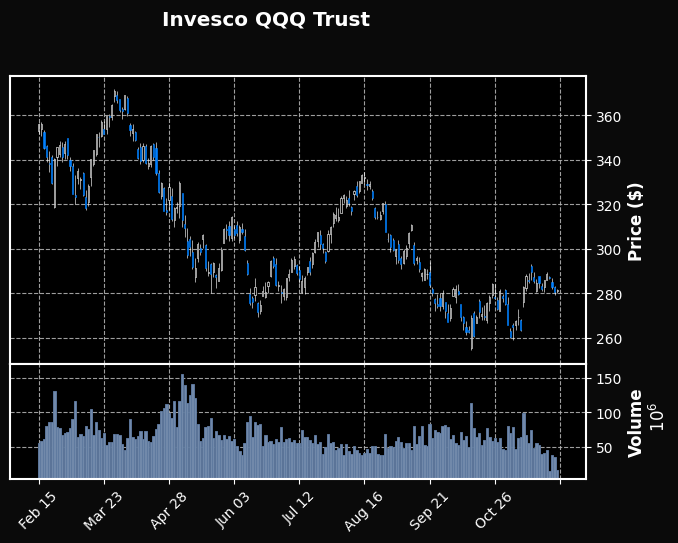

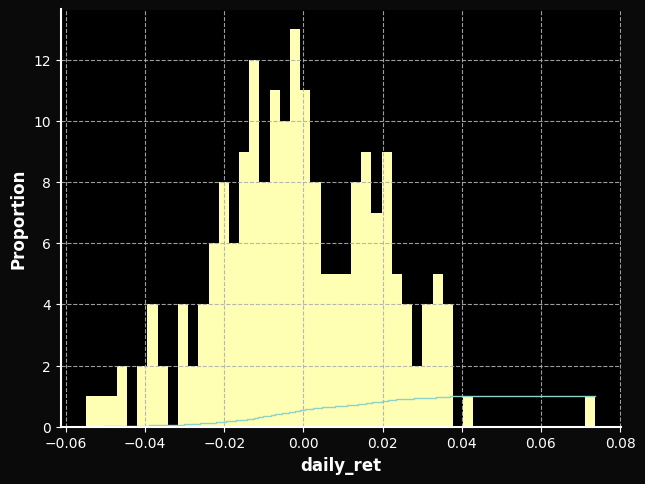

In [59]:
#@title

fplt.plot(
            data,
            type='candle',
            style='mike',
            title=Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            )


data['daily_ret'] = data['Close'].pct_change(1)

sns.displot(data, x="daily_ret", kind="ecdf")

data['daily_ret'].hist(bins = 50,figsize = (7,5))

[*********************100%***********************]  1 of 1 completed



Related News – BTC-USD



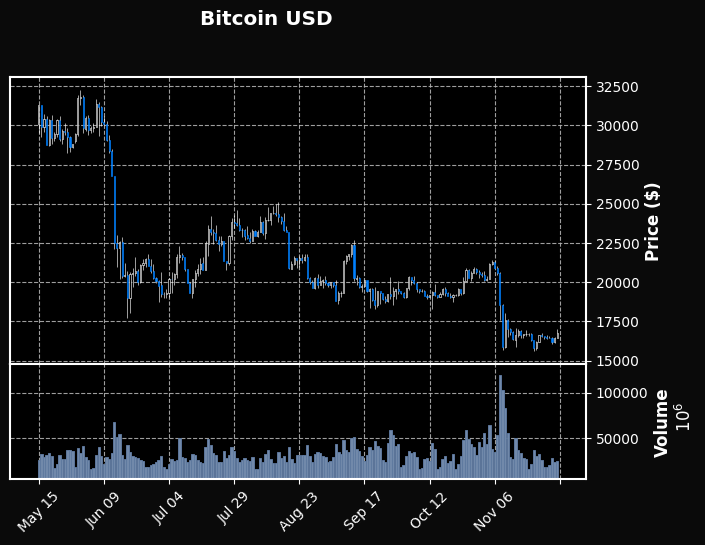

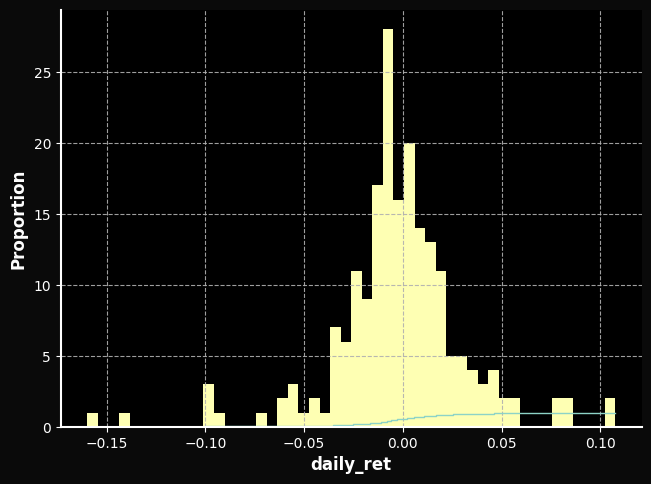

In [60]:
#@title Bitcoin
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go

ticker='BTC-USD'


ticker_y = yf.Ticker(ticker)
Name = ticker_y.info['shortName']
ticker_y.info

data = yf.download(tickers=ticker, period='200d')

fig = go.Figure(data=[go.Candlestick(x=data.index,
                                     open=data['Open'],
                                     high=data['High'],
                                     low=data['Low'],
                                     close=data['Close'])])

fig.update_layout(
    title=Name,
    yaxis_title='Price',
   
)

fig.show()
ticker_y.info

print('')
print('Related News – ' +ticker)
print('')

try:
  for i in range(1,10):
    print('– ' + ticker_y.news[i]['title'])

except Exception:
  pass
  
fplt.plot(
            data,
            type='candle',
            style='mike',
            title=Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            )
data['daily_ret'] = data['Close'].pct_change(1)

sns.displot(data, x="daily_ret", kind="ecdf")

data['daily_ret'].hist(bins = 50,figsize = (7,5))

[*********************100%***********************]  1 of 1 completed



Related News – ETH-USD

– Expanding the Possibilities With Quest Advanced(R) Neurology
– Cyber Monday 2022 isn't over yet—here are 150+ deals you can still shop
– Enterprise’s SPOT Project Receives Record of Decision
– UNDER CANVAS ANNOUNCES OPENING OF NEW LOCATION NEAR NORTH ENTRANCE OF YELLOWSTONE NATIONAL PARK
– Lovett Industrial Finalizes 6-Acre Land Acquisition in California’s Inland Empire for Industrial Development
– Impact Podcast with John Shegerian Features TIME’s and CO2.com’s Simon Mulcahy
– Global Synthetic Beta Carotene Market to Reach $409.9 Million by 2027


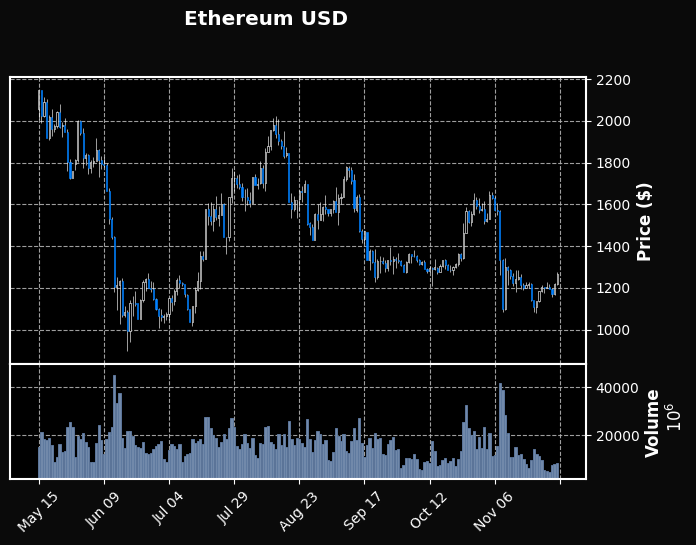

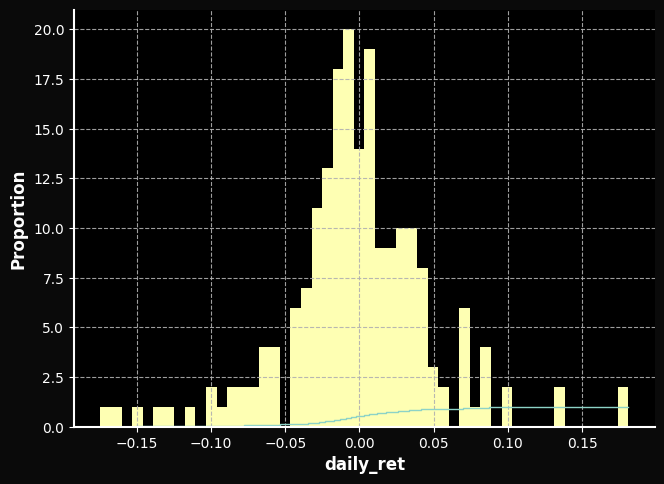

In [61]:
#@title Ethereum
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go

ticker='ETH-USD'


ticker_y = yf.Ticker(ticker)
Name = ticker_y.info['shortName']
ticker_y.info

data = yf.download(tickers=ticker, period='200d')

fig = go.Figure(data=[go.Candlestick(x=data.index,
                                     open=data['Open'],
                                     high=data['High'],
                                     low=data['Low'],
                                     close=data['Close'])])

fig.update_layout(
    title=Name,
    yaxis_title='Price',
   
)

fig.show()
ticker_y.info

print('')
print('Related News – ' +ticker)
print('')

try:
  for i in range(1,10):
    print('– ' + ticker_y.news[i]['title'])

except Exception:
  pass

  
fplt.plot(
            data,
            type='candle',
            style='mike',
            title =Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            )

data['daily_ret'] = data['Close'].pct_change(1)

sns.displot(data, x="daily_ret", kind="ecdf")

data['daily_ret'].hist(bins = 50,figsize = (7,5))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DXY: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


<Figure size 640x480 with 0 Axes>

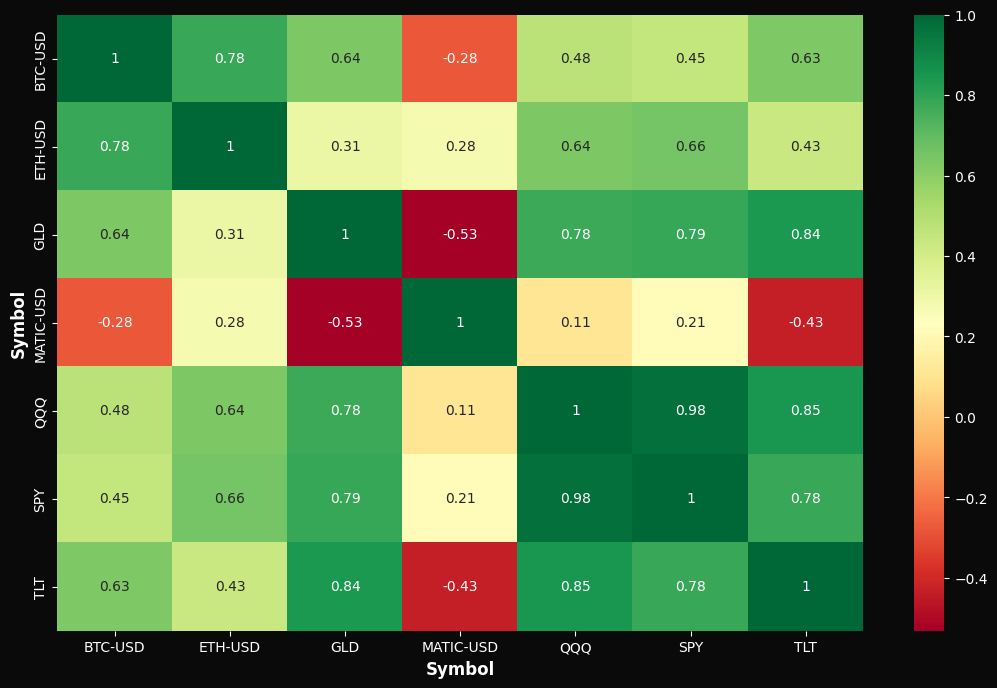

<Figure size 640x480 with 0 Axes>

In [54]:
#@title Correlation

import numpy as np 
import pandas as pd 
# Used to grab the stock prices, with yahoo 
import pandas_datareader as web 
from datetime import datetime 
# To visualize the results 
import matplotlib.pyplot as plt 
import seaborn

start = datetime(2022,9, 1)
symbols_list = [yahoo_id,'SPY', 'QQQ', 'ETH-USD', 'BTC-USD', 'TLT', 'DXY', 'GLD']
#array to store prices
symbols=[]

#array to store prices
symbols=[]
for ticker in symbols_list:     
    
    r = yf.download(tickers=ticker, period='200d')
    # add a symbol column   
    r['Symbol'] = ticker    
    symbols.append(r)
# concatenate into df
df = pd.concat(symbols)
df = df.reset_index()
df = df[['Date', 'Close', 'Symbol']]
df.head()
df_pivot=df.pivot('Date','Symbol','Close').reset_index()
df_pivot.head()
corr_df = df_pivot.corr(method='pearson')
#reset symbol as index (rather than 0-X)
corr_df.head().reset_index()
#del corr_df.index.name
corr_df.head(10)
plt.figure(figsize=(13, 8))
seaborn.heatmap(corr_df, annot=True, cmap='RdYlGn')
plt.figure()

# Intraday Fundamentals

Connect to screener database

Trade Management

In [64]:
#@title

import requests
import datetime
import time
import json
from google.colab import data_table
from pycoingecko import CoinGeckoAPI
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq


cg = CoinGeckoAPI()

  
response = requests.get("https://api.coingecko.com/api/v3/coins/{}".format(CoinGecko_id))
output = response.text
json_parsed = json.loads(output)
  

links = 'Complete list: '+str(json_parsed['links'])
chat_url = 'Chat: '+str(json_parsed['links']['chat_url'])
Twitters = 'Twitter: '+str('https://twitter.com/')+str(json_parsed['links']['twitter_screen_name'])
homepage = 'Homepage: '+str(json_parsed['links']['homepage'])
subreddit_url =  'Reddit: ' +str(json_parsed['links']['subreddit_url'])
pd.set_option('display.width', 10)

print('')
print('WEB Links')
print('')
print(homepage)
print(Twitters)
print(subreddit_url)
print(chat_url)


print(links)

print('')  
print('MARKET DATA')  
print('')  


market_cap = json_parsed['market_data']['market_cap']['usd']
circulating_supply = json_parsed['market_data']['circulating_supply']
# circulating_supply.astype(int) 
current_price = json_parsed['market_data']['current_price']['usd']
# current_price.astype(int) 
fdv_to_tvl_rati = json_parsed['market_data']['fdv_to_tvl_ratio']
# fdv_to_tvl_ratio.astype(int) 
fully_diluted_valuation = json_parsed['market_data']['fully_diluted_valuation']['usd']
# fully_diluted_valuation
max_supply = json_parsed['market_data']['max_supply']
mcap_to_tvl_ratio = json_parsed['market_data']['mcap_to_tvl_ratio']
total_supply = json_parsed['market_data']['total_supply']
#total_value_locked = json_parsed['market_data']['total_value_locked']['usd']
total_volume = json_parsed['market_data']['total_volume']['usd']

float_rotation_24h = total_volume / market_cap
circulating_cap = current_price * json_parsed['market_data']['circulating_supply']
total_cap = current_price * total_supply
max_cap = current_price * max_supply 
supply_expansion_multiple = max_supply  / circulating_supply


print('')  
try:
  
  circulating_versus_max = circulating_supply/total_supply
  market_cap_dilution_ratio =  fully_diluted_valuation / market_cap
  
  dict_custom = {}
  dict_custom['float_rotation_24h'] = float_rotation_24h
  dict_custom['supply_expansion_multiple'] = supply_expansion_multiple
  dict_custom['circulating_versus_max'] = circulating_versus_max
  dict_custom['market_cap_dilution_ratio'] = market_cap_dilution_ratio - 1
except ZeroDivisionError:
  print('null')
  
print(dict_custom )

print('          ') 


df_market = {}
df_market['market_cap'] = market_cap
#Final been up what is on the national emergency, informative or what basket is something the P is the spaciousness up to Sarah  ankedat1['circulating_supply'] = circulating_supply
df_market['current_price'] = current_price
# df_market['fdv_to_tvl_ratio'] = fdv_to_tvl_ratio#
df_market['fully_diluted_valuation'] = fully_diluted_valuation
# ankedat1['max_supply'] = max_supply
df_market['mcap_to_tvl_ratio'] = mcap_to_tvl_ratio
df_market['total_supply'] = total_supply
#df_market['total_value_locked'] = total_value_locked
df_market['mcap_to_tvl_ratio'] = mcap_to_tvl_ratio
df_market['total_volume'] = total_volume


df_market




print('          ')  
print('PRICE ACTION')  
price_change_percentage_7d = json_parsed['market_data']['price_change_percentage_7d']
price_change_percentage_14d = json_parsed['market_data']['price_change_percentage_14d']
price_change_percentage_30d = json_parsed['market_data']['price_change_percentage_30d']
price_change_percentage_60d = json_parsed['market_data']['price_change_percentage_60d']
price_change_percentage_200d = json_parsed['market_data']['price_change_percentage_200d']
price_change_percentage_1y = json_parsed['market_data']['price_change_percentage_1y']



dict_return = {}
dict_return['price_change_percentage_7d'] = price_change_percentage_7d
dict_return['price_change_percentage_14d'] = price_change_percentage_14d
dict_return['price_change_percentage_30d'] = price_change_percentage_30d
dict_return['price_change_percentage_60d'] = price_change_percentage_60d
dict_return['price_change_percentage_200d'] = price_change_percentage_200d
dict_return['price_change_percentage_1y'] = price_change_percentage_1y

print(dict_return)



category = json_parsed['categories']

print('')  
print('CATEGORIES')  
print(category)
  



description  = [] 
pd.set_option('display.width', 10)
pd.set_option("display.max_rows", None, "display.max_columns", None)
description = json_parsed['description']['en']

print('')  
print('DESCRIPTION: ')
print(description)


links = json_parsed['links']



#





WEB Links

Homepage: ['http://bosonprotocol.io', '', '']
Twitter: https://twitter.com/BosonProtocol
Reddit: None
Chat: ['', '', '']
Complete list: {'homepage': ['http://bosonprotocol.io', '', ''], 'blockchain_site': ['https://etherscan.io/token/0xC477D038d5420C6A9e0b031712f61c5120090de9', 'https://ethplorer.io/address/0xc477d038d5420c6a9e0b031712f61c5120090de9', '', '', '', '', '', '', '', ''], 'official_forum_url': ['', '', ''], 'chat_url': ['', '', ''], 'announcement_url': ['https://medium.com/bosonprotocol', ''], 'twitter_screen_name': 'BosonProtocol', 'facebook_username': '', 'bitcointalk_thread_identifier': None, 'telegram_channel_identifier': 'bosonprotocol', 'subreddit_url': None, 'repos_url': {'github': ['https://github.com/bosonprotocol'], 'bitbucket': []}}

MARKET DATA


{'float_rotation_24h': 0.11887457735825811, 'supply_expansion_multiple': 1.9217763206685223, 'circulating_versus_max': 0.5203519209, 'market_cap_dilution_ratio': 0.9217762828540235}
          
          
PRI

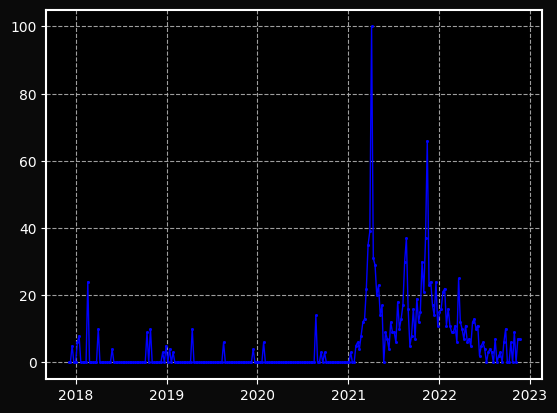

In [86]:
#@title

 
import datetime
import time
import json
from google.colab import data_table
from pycoingecko import CoinGeckoAPI
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq


cg = CoinGeckoAPI()

a = cg.get_coin_ohlc_by_id(id=CoinGecko_id, vs_currency='usd', days = 7 )


df = pd.DataFrame(data=a, columns = ['Date','Open','High', 'Low', 'Close'])

df['datetime'] = pd.to_datetime(df['Date'], unit='ms')

fig2 = go.Figure(data=[go.Candlestick(x=df['datetime'],open=df['Open'], high=df['High'],low=df['Low'], close=df['Close'])])
                      
fig2.show()

# Only need to run this once, the rest of requests will use the same session.
pytrend = TrendReq()

# Create payload and capture API tokens. Only needed for interest_over_time(), interest_by_region() & related_queries()
keyword = str(CoinGecko_id)
keyword = keyword.replace('-',' ')
pytrend.build_payload(kw_list=[keyword])

# Interest Over Time
interest_over_time_df = pytrend.interest_over_time()
df=interest_over_time_df

#print(interest_over_time_df.tail(10))
# multiple line plot
# multiple line plot
plt.plot( keyword, 'y1', data=df, marker='x', color='blue',linestyle='-', linewidth=1,ms=1.5 )

# Twitter